In [43]:
import matplotlib
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

# Para manejar los archivos y automatizar la lectura en directorios
import csv
import os
# Fontsize
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
# Latex font
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

%matplotlib inline

# Nombres de archivo, paths y definiciones
La informacion de redshift solo se encuentra en los halos lvl3 dado que se necesita mucha resolucion a alto redshift donde el halo es mas pequeno

In [44]:
# SOME DEFINITIONS
# The directory where information lies
direc = '../Data/Halo_Detail/'
# Level of the simulation 
lvl = 'level3_'
# If DM or MHD
sim_det = 'DM'

# la carpeta completa
lvl = lvl+sim_det

# Halos de la simulacion de nivel 3
halos = [6,16,21,23,24,27]
#halos = [24]

# Data format
El formato de la data se explica con la siguiente funcion

In [45]:
# En esta funcion se obtiene la data de un halo dadas sus especificaciones
# Parametros necesarios:
# directorio - el directorio donde se encuentran los datos
# level      - el nivel de la simulacion incluyendo si es DM o MHD
# halo       - el numero del halo
# Retorna:
# Una lista de arrays con el radial profile y su respectivo redshift
def get_data(directorio,level,halo):
    # El path en donde esta la informacion
    path = directorio+level+'/halo_'+str(halo)
    
    # List of directories
    # Cada radial profile esta en una carpeta diferente para redshift diferentes
    # Se obtienen las carpetas de los redshifts
    listdir = next(os.walk(path))[1]
    if 'rand_sample' in listdir:
        listdir.remove('rand_sample')
    # Retorna el numero del snapshot para ordenar
    def getkey(l):
        return int(l.split("_")[1])
    # ordena por numero de snapshot
    listdir.sort(key=getkey)
    #print(listdir)
    
    # La lista en la que se van a guardar los radial profiles
    list_radial_profiles = []
    # Obtiene la informacion para cada subdirectorio
    for sub_dir in listdir:
        # Loads information dictionary
        # Esta informacion es cargada en info.npy como un objeto de numpy
        # y se carga de la siguiente manera
        info = np.load(path+"/"+sub_dir+"/info.npy",encoding = 'latin1')
        # Por ahora solo queremos el redshift\
        # Pero contiene informacion del scale factor y los radios R_DM,R_BH y R_Star
        redshift = info.item().get('Redshift')
        #print("Redshift: "+str(redshift))
        
        #if redshift > 2:        
        # Semiaxes
        # Se cargan los semiejes en formato a,b,c 
        # el radio de sampleo es la media geometrica de abc
        arr = np.loadtxt(path+"/"+sub_dir+"/s"+sub_dir.split("_")[1]+".txt", delimiter = ",")

        # anade la informacion

        list_radial_profiles.append([redshift,arr])
    
    return list_radial_profiles
    

# Usage
### Ejemplo de uso en el perfil radial en el redshift

In [42]:
# The geometric mean
from scipy.stats.mstats import gmean
# Fonts 
MEDIUM_SIZE = 30
SMALL_SIZE = 25
SSSMALL_SIZE = 17
plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

#halonums = [24]
with PdfPages("../Graphs/Redshift_"+lvl+".pdf") as pdf:
    for halo in halos:
        print(halo)

        # Load the ddata
        data_halo = get_data(direc,lvl,halo)
        #print(data_halo)

        # Plots    
        ylabel = ['b/a','c/a','T']
        fig, axs = plt.subplots(figsize=(10,15),nrows=3)

        # Color settings for redshift
        my_norm = colors.Normalize(0.0,0.4)
        mapa = cm.ScalarMappable(norm=my_norm, cmap="CMRmap")

        for redshift,axes in data_halo:
            print(redshift)
            # Axial ratios and radii (including rvir)
            # Cuidado con la dimension del array
            if axes.ndim > 1:
                a,b,c = axes[:-1].T
            else: 
                a,b,c = axes
            xvals = (a*b*c)**(1./3.)
            # Cantidades a plotear
            yvals = np.array([b/a,c/a,(a**2-b**2)/(a**2-c**2)])
            
            #print(yvals)
            # Virial rad
            rvir = 0
            # Cuidado con la dimension de los semiejes
            # a veces se tiene baja resolucion y es solo un datao para ejes
            if axes.ndim == 1:
                rvir = gmean(axes)
            else:
                rvir = gmean(axes[-1])

            mappable = 0
            # Hace la grafica para cada eje
            for ax,yval,ylab in zip(axs,yvals,ylabel):
                
                # Define el color para el redshift
                my_col = mapa.to_rgba(1.-(1.0/(1.0+redshift)))
                
                # para tener solo un label 
                if(redshift < 1e-6):
                    mappable = ax.plot(xvals,yval, color = my_col, linewidth=1, label = "Radial shape", alpha = 1,zorder=10)
                    ax.plot([rvir,rvir],[0,0.5], color = my_col, linestyle = '-.',label = r"$R_{500}$",zorder =1)
                else:
                    mappable = ax.plot(xvals,yval, color = my_col, linewidth=0.5,  alpha = 1,zorder = 10)
                    ax.plot([rvir,rvir],[0,0.5], color = my_col,linestyle = '-.',zorder=1)

                # Major ticks every 20, minor ticks every 5
                major_ticksy = np.linspace(0, 1, 3)
                minor_ticksy = np.linspace(0, 1, 11)
                major_ticksx = np.logspace(-1, 2, 3)
                minor_ticksx = np.logspace(-1, 2, 30)

                ax.set_xticks(major_ticksx)
                ax.set_xticks(minor_ticksx, minor=True)
                ax.set_yticks(major_ticksy)
                ax.set_yticks(minor_ticksy, minor=True)
                ax.grid(which='both')
                ax.grid(which='minor', alpha=0.3)
                ax.grid(which='major', alpha=0.6)
                
                # Log scale for radius
                ax.set_xscale('log')
                ax.set_ylabel(ylab)

                # Plotting ratios
                ax.set_ylim(0,1)

                # Axs specs
                ax.set_xlim(3,rvir+30)
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

                # Hide axes 
                plt.setp( ax.get_xticklabels(), visible=False)                


        # Axs specs  
        #axs[0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))  

        xticks = [0, 0.5, 1, 2]
        yticks = [1.- 1.0/(1.0+x) for x in xticks]

        # Colorbar ax
        cbaxes = fig.add_axes([0.95, 0.1, 0.02, 0.8]) 
        cbar = mpl.colorbar.ColorbarBase(cbaxes, cmap = "CMRmap", norm = my_norm, orientation = 'vertical', ticks = yticks )  
        cbar.ax.set_yticklabels(xticks)
        cbar.set_label('$Redshift$', fontsize=30 )

        axs[-1].legend(loc = 0)
        axs[-1].set_xlabel("R(Kpc/h)")
        plt.setp( axs[-1].get_xticklabels(), visible=True)                
        #axs[0].set_title(halo+"  Rvir="+str(rvir)+"Kpc" )  
        #axs[0].set_title(halo)  

        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

6
15.4502666289


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars


10.3674435724
6.85511726265
8.44947629437
7.59510714987
6.85511726265
6.14490120342
5.52976580795
4.93938066349
4.42803373661
3.93726108473
3.49086136926
3.08482263583
2.73314261732
2.44422570455
2.20792547238
2.20792547238
2.00202813925
2.00202813925
1.82268925262
1.66666955611
1.53123902916
1.41409822037
1.30237845991
1.20625808078
1.11415056377
1.03551044566
0.950531351585
0.886896937575
0.816709979012
0.757441372616
0.700106353719
0.644641840685
0.598543288188
0.546392183141
0.503047523245
0.460917794181
0.419968941997
0.38016786726
0.347853841858
0.310074120128
0.273353346578
0.243540181555
0.214425035514
0.180385261706
0.152748768902
0.125759332411
0.0994018026302
0.0736613846564
0.0485236299818
0.0239744283828
2.22044604925e-16
16
15.4502666289
10.3674435724
6.85511726265
4.42803373661
2.73314261732
1.82268925262
1.30237845991
0.950531351585
0.700106353719
0.503047523245
0.347853841858
0.214425035514
0.0994018026302
0.0485236299818
0.0239744283828
2.22044604925e-16
21
0.70010635

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


24
0.460917794181
0.419968941997
0.38016786726
0.347853841858
0.310074120128
0.273353346578
0.243540181555
0.214425035514
0.180385261706
0.152748768902
0.125759332411
0.0994018026302
0.0736613846564
0.0485236299818
0.0239744283828
2.22044604925e-16
27


### Ejemplo de uso obteniendo el radio virial en funcion del redshift

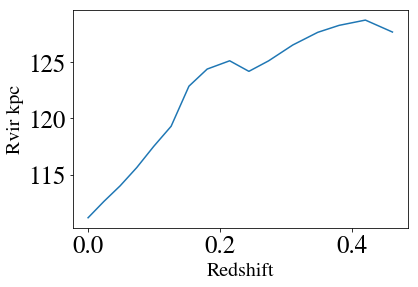

In [11]:
# The geometric mean
from scipy.stats.mstats import gmean

# El primer Halo
specific_halo = halos[0]
# Tomamos los datos
data_halo = get_data(direc,lvl,specific_halo)
# Vamos a plotear el radio virial (ultimo radio sampleado), en funcion del redshift
redshift = []
vir_rad = []
for red,axes in data_halo:
    redshift.append(red)
    rvir = 0
    # Cuidado con la dimension de los semiejes
    # a veces se tiene baja resolucion y es solo un datao para ejes
    if axes.ndim == 1:
        rvir = gmean(axes)
    else:
        rvir = gmean(axes[-1])
    vir_rad.append(rvir)
    
redshift = np.array(redshift)  
vir_rad = np.array(vir_rad)
indices = np.argsort(redshift)
plt.plot(redshift[indices],vir_rad[indices])
plt.xlabel('Redshift',fontsize =20)
plt.ylabel('Rvir kpc',fontsize =20)
plt.show()

# Data 2
Ademas de la estructura de datos anteriormente presentada, se tiene, para cada halo un resumen de la caracterizacion de triaxialidad en el radio virial y en funcion del redshift.

Esta se encuentra principalmente en el archivo Z_axes.txt, el cual tiene el formato:

Z,a,b,c 

Z2,a2,b2,c2

Z3,a3,b3,c3

Z4,a4,b4,c4
...

Con estos datos podremos reconstruir la historia del halo restringida al radio virial:

# Correlacion historico en radio virial vs radial en Z =0
# en el plano triaxial

In [48]:
# SOME DEFINITIONS
# The directory where information lies
direc = '../Data/Halo_Detail/'
# Level of the simulation 
lvl = 'level3_'
# If DM or MHD
sim_det = 'DM'

# la carpeta completa
lvl = lvl+sim_det

# Halos de la simulacion de nivel 3
halos = [6,16,21,23,24,27]

In [49]:
# 

# Keeps semiaxes and eigenvecs
with PdfPages("../Graphs/"+"Z_Triax_"+lvl+".pdf") as pdf:

    # Recorre los halos
    for j in halos:
    
        # Halo name        
        halo = "halo_"+str(j)     
        print("------------------------------------"+halo)   
    
        # Paths to file
        path = direc+lvl+"/"+halo
        
        # Loads redshift and axes abc at rvir
        arr = np.loadtxt(path+"/"+"Z_axes.txt", delimiter = ",")
        # Este es el formato del archivo
        redshift,a,b,c = arr.T  

        # Fonts 
        MEDIUM_SIZE = 30
        SMALL_SIZE = 25
        SSSMALL_SIZE = 20
        plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        
        # Plots    
        fig, axs = plt.subplots(figsize=(10,10))
        
        # Color settings
        my_norm = colors.Normalize(0.0,0.8)
        mapa = cm.ScalarMappable(norm=my_norm, cmap='CMRmap')      
        
        for j in range(len(a)):
            
            # Not that much history
            if redshift[j] > 1.5:
                continue
            print("Redshift: "+str(redshift[j]))
            # Plot scatter point
            my_col = mapa.to_rgba(1-(1.0/(1.0+redshift[j])))
            if redshift[j] < 1e-6:
            
                axs.scatter(b[j]/a[j],c[j]/a[j], color = my_col, s=90, alpha = 1, zorder = len(a)-j,label = r"Historical shape $R_{500}$")
            else:
                axs.scatter(b[j]/a[j],c[j]/a[j], color = my_col, s=90, alpha = 1, zorder = len(a)-j)
            
            if redshift[j+1] < 1.5:
                axs.plot([b[j]/a[j],b[j+1]/a[j+1]],[c[j]/a[j],c[j+1]/a[j+1]], color = my_col, linewidth=3, alpha = 1, zorder = len(a)-j)
            


                
                
        # Plots last snapshot in terms of radius
        arr = np.loadtxt(path+"/"+"abc_"+lvl+"_"+halo+".txt", delimiter = ",")
        a,b,c = (arr)[:-1].T
        rvir =  arr[-1][0]
        xvals = (a*b*c)**(1./3.)
        # Axial ratios and radii (including rvir)
        a,b,c = (arr[:-1][xvals>=1]).T
        xvals = (a*b*c)**(1./3.)
        
        # Radius at which comparison is performed (in kpc)
        axs.plot((b/a)[xvals>rvir],(c/a)[xvals>rvir], color = 'black', linewidth=2, alpha = 1, linestyle = "--", zorder = len(a))
        axs.plot((b/a)[xvals<rvir],(c/a)[xvals<rvir], color = 'black', linewidth=2, alpha = 1, linestyle = "--", zorder = len(a),label="Radial shape z = 0")
    
        # Axs specs
        axs.plot([0,1],[0,1], linewidth= 2, c = 'black')
        axs.set_xlabel("b/a")
        axs.set_ylabel("c/a")
        axs.set_title(halo)
        
         # grid!!
        # Major ticks every 20, minor ticks every 5
        major_ticksy = np.linspace(0, 1, 3)
        minor_ticksy = np.linspace(0, 1, 11)
        #major_ticksx = np.logspace(-1, 2, 3)
        #minor_ticksx = np.logspace(-1, 2, 30)

        axs.set_xticks(major_ticksy)
        axs.set_xticks(minor_ticksy, minor=True)
        axs.set_yticks(major_ticksy)
        axs.set_yticks(minor_ticksy, minor=True)
        axs.grid(which='both')
        axs.grid(which='minor', alpha=0.3)
        axs.grid(which='major', alpha=0.6)

        axs.set_xlim(0,1)
        axs.set_ylim(0,1)
        #axs.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        # Colorbar
        xticks = [0, 0.5, 1,2]
        yticks = [1.- 1.0/(1.0+x) for x in xticks]
        
        # Colorbar ax
        cbaxes = fig.add_axes([0.95, 0.1, 0.02, 0.8]) 
        
        axs.legend(loc=0)
        cbar = mpl.colorbar.ColorbarBase(cbaxes, cmap = "CMRmap", norm = my_norm, orientation = 'vertical', ticks = yticks )  
        cbar.ax.set_yticklabels(xticks)
        cbar.set_label('$Redshift$', fontsize=30 )
        
        # Save
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()


------------------------------------halo_6
Redshift: 2.22044604925e-16
Redshift: 0.00952166696794
Redshift: 0.0239744283828
Redshift: 0.0337243718735
Redshift: 0.0485236299818
Redshift: 0.0585073227945
Redshift: 0.0736613846564
Redshift: 0.0838844307975
Redshift: 0.0994018026302
Redshift: 0.109869940459
Redshift: 0.125759332411
Redshift: 0.14187620397
Redshift: 0.152748768902
Redshift: 0.169252033244
Redshift: 0.180385261706
Redshift: 0.197284182376
Redshift: 0.214425035514
Redshift: 0.22598838626
Redshift: 0.243540181555
Redshift: 0.261343256161
Redshift: 0.273353346578
Redshift: 0.291583239722
Redshift: 0.310074120128
Redshift: 0.328829724206
Redshift: 0.347853841858
Redshift: 0.360687657262
Redshift: 0.38016786726
Redshift: 0.399926964614
Redshift: 0.419968941997
Redshift: 0.440297849248
Redshift: 0.460917794181
Redshift: 0.481832943421
Redshift: 0.503047523245
Redshift: 0.524565820434
Redshift: 0.546392183141
Redshift: 0.575980845108
Redshift: 0.598543288188
Redshift: 0.62142874524

In [14]:
len(data_halo)

16